In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import math
import time

import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from tqdm import tqdm


In [7]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Fixed random weights
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale,
                              requires_grad=False)
    def forward(self, t):
        """
        t shape: (batch,)  -- real-valued
        returns shape: (batch, embed_dim)
        """
        # Expand t to (batch,1)
        t = t.view(-1, 1)
        x_proj = t * self.W[None,:] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.linear(x)[..., None, None]


class ScoreNet(nn.Module):
    """
    A time-dependent score-based model built upon a small U-Net structure.
    We'll keep it simple for demonstration.
    """
    def __init__(self, channels=[32,64,128,256], embed_dim=256):
        super().__init__()
        # Time embedding
        self.embed_time = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding

        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, padding=1)         # 28×28 -> 28×28
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1)  # 28×28 -> 14×14
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1) # 14×14 -> 7×7
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1)  # 7×7   -> 4×4
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, channels[3])

        # Decoding
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=0)  # 4×4 -> 7×7
        self.dense5  = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2]*2, channels[1], 3, stride=2, padding=1, output_padding=1) # 7×7 -> 14×14
        self.dense6  = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1]*2, channels[0], 3, stride=2, padding=1, output_padding=1) #14×14-> 28×28
        self.dense7  = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0]*2, 1,          3, stride=1, padding=1)                   #28×28-> 28×28

        self.act = lambda x: x*torch.sigmoid(x)

    def forward(self, x, t):
        """
        x shape: (batch,1,28,28)
        t shape: (batch,)
        Return: score (batch,1,28,28)
        """
        # embed time
        emb = self.embed_time(t)  # shape (batch, embed_dim)
        emb = self.act(emb)

        # Encoding
        h1 = self.conv1(x)
        h1 += self.dense1(emb)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)

        h2 = self.conv2(h1)
        h2 += self.dense2(emb)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)

        h3 = self.conv3(h2)
        h3 += self.dense3(emb)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)

        h4 = self.conv4(h3)
        h4 += self.dense4(emb)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding
        u4 = self.tconv4(h4)
        u4 += self.dense5(emb)
        u4 = self.tgnorm4(u4)
        u4 = self.act(u4)

        u3 = self.tconv3(torch.cat([u4, h3], dim=1))
        u3 += self.dense6(emb)
        u3 = self.tgnorm3(u3)
        u3 = self.act(u3)

        u2 = self.tconv2(torch.cat([u3, h2], dim=1))
        u2 += self.dense7(emb)
        u2 = self.tgnorm2(u2)
        u2 = self.act(u2)

        u1 = self.tconv1(torch.cat([u2, h1], dim=1))
        # no final activation => can be linear
        return u1

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [15]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class VPSDE(nn.Module):
    """
    Variance Preserving SDE (Continuous) with linear beta(t).
    x'(t) = -0.5 beta(t) x(t) + sqrt(beta(t)) * noise
    """
    def __init__(self, score_model, beta_min=0.1, beta_max=20.0):
        super().__init__()
        self.model = score_model  # ScoreNet
        self.beta_min = beta_min
        self.beta_max = beta_max

    def beta_t(self, t):
        """
        beta(t) = beta_min + t*(beta_max-beta_min)
        """
        return self.beta_min + (self.beta_max - self.beta_min)*t

    def alpha_t(self, t):
        """
        alpha(t) = exp(-0.5 \int_0^t beta(s) ds)
        = exp(-0.5 [ beta_min*t +  (beta_max - beta_min)*t^2/2 ])
        We'll define a small function phi(t):
        """
        phi = self.beta_min*t + 0.5*(self.beta_max - self.beta_min)*(t**2)
        return torch.exp(-0.5 * phi)

    def forward_diffusion(self, x0, t):
        """
        x(t) ~ alpha(t)*x0 + sqrt(1 - alpha(t)^2)* N(0,1).
        Derived from the closed-form solution of the linear VP-SDE.
        """
        # x0 shape: (batch, 784) or (batch,1,28,28)
        # t shape: (batch,)
        a_t = self.alpha_t(t)   # shape (batch,)
        a_t_2d = a_t.view(-1,1,1,1)  # for broadcasting

        z = torch.randn_like(x0)
        # if x0 is (batch,784), reshape to (batch,1,28,28)
        return a_t_2d*x0 + torch.sqrt(1.0 - a_t_2d**2)*z

    def continuous_score_loss(self, x0):
        """
        1) sample t ~ Uniform(0,1)
        2) x(t) from forward_diffusion
        3) true score = ?
        4) model_score = self.model(...)
        5) MSE
        """
        batch_size = x0.shape[0]
        device = x0.device

        t = torch.rand(batch_size, device=device)  # (batch,)
        xt = self.forward_diffusion(x0, t)         # shape (batch,1,28,28)

        # simple reparameterization approach:
        a_t = self.alpha_t(t).view(-1,1,1,1)  # (batch,1,1,1)
        score_target = -(xt - a_t*x0) / (1.0 - a_t**2 + 1e-5)

        # model prediction
        model_score = self.model(xt, t)  # shape (batch,1,28,28)

        # MSE
        loss = 0.5 * (score_target - model_score).square().mean()
        return loss

    def loss(self, x0):
        return self.continuous_score_loss(x0)

    @torch.no_grad()
    def pf_ode_sample(self, batch_size, device, num_steps=1000):
        """
        Probability Flow ODE:
        dx/dt = f(x,t) - 0.5*g(t)^2 * score(x,t).
        For the VP-SDE:
          f(x,t) = -0.5 beta(t) x,
          g(t) = sqrt( beta(t) ).
        We'll do Euler method from t=1 down to t=0.
        Return final x(0).

        Also track log_px for exact log-likelihood if desired:
        d log_px / dt = -divergence( f - 0.5*g^2*s ), but we approximate
        for the VP-SDE.
        """
        x = torch.randn(batch_size, 1, 28, 28, device=device)  # x(1)
        log_px = torch.zeros(batch_size, device=device)         # track log probability

        dt = -1.0 / num_steps
        t_eval = torch.linspace(1.0, 0.0, num_steps+1, device=device)

        for i in range(num_steps):
            t_i = t_eval[i]
            t_i_next = t_eval[i+1]
            t_mid = 0.5*(t_i + t_i_next)

            # from t_i -> t_i_next
            # Evaluate f, g, score at t_i
            beta_i = self.beta_t(t_i)
            f_i = -0.5 * beta_i * x
            g_i = torch.sqrt(beta_i)
            s_i = self.model(x, t_i.expand(batch_size))  # shape (batch,1,28,28)

            # ODE: dx/dt = f_i - 0.5*g_i^2 * s_i
            # We do Euler
            dx = (f_i - 0.5*g_i*g_i * s_i) * dt
            x = x + dx
        return x, log_px


def train_sde(model, dataloader, device, epochs=10, lr=1e-4):
    """
    model: an instance of VPSDE
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    losses_per_epoch = [] 
    start_time = time.time()

    for epoch in range(1, epochs+1):
        losses = []
        for x, _ in dataloader:
            x = x.to(device)
            # x shape: (B, 784) or (B,1,28,28).
            # Suppose we reshape to (B,1,28,28).
            x = x.view(-1,1,28,28)

            optimizer.zero_grad()
            loss_val = model.loss(x)
            loss_val.backward()
            optimizer.step()
            losses.append(loss_val.item())

        losses_per_epoch.append(np.mean(losses)) 
        print(f"Epoch {epoch}/{epochs}, Loss: {np.mean(losses):.4f}")

    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")
    return losses_per_epoch

Epoch 1/100, Loss: 18.3692
Epoch 2/100, Loss: 16.0583
Epoch 3/100, Loss: 15.8039
Epoch 4/100, Loss: 12.6142
Epoch 5/100, Loss: 12.4732
Epoch 6/100, Loss: 13.3113
Epoch 7/100, Loss: 10.7922
Epoch 8/100, Loss: 11.3156
Epoch 9/100, Loss: 10.9840
Epoch 10/100, Loss: 11.3179
Epoch 11/100, Loss: 10.8373
Epoch 12/100, Loss: 9.0718
Epoch 13/100, Loss: 11.2452
Epoch 14/100, Loss: 9.5848
Epoch 15/100, Loss: 9.6316
Epoch 16/100, Loss: 8.6839
Epoch 17/100, Loss: 8.2278
Epoch 18/100, Loss: 8.7644
Epoch 19/100, Loss: 9.7473
Epoch 20/100, Loss: 8.7250
Epoch 21/100, Loss: 8.7799
Epoch 22/100, Loss: 7.7846
Epoch 23/100, Loss: 8.4449
Epoch 24/100, Loss: 7.8874
Epoch 25/100, Loss: 8.9191
Epoch 26/100, Loss: 8.3507
Epoch 27/100, Loss: 9.3914
Epoch 28/100, Loss: 7.1416
Epoch 29/100, Loss: 6.7806
Epoch 30/100, Loss: 8.4779
Epoch 31/100, Loss: 8.5279
Epoch 32/100, Loss: 8.7326
Epoch 33/100, Loss: 8.6715
Epoch 34/100, Loss: 6.4791
Epoch 35/100, Loss: 8.1277
Epoch 36/100, Loss: 7.2056
Epoch 37/100, Loss: 6.471

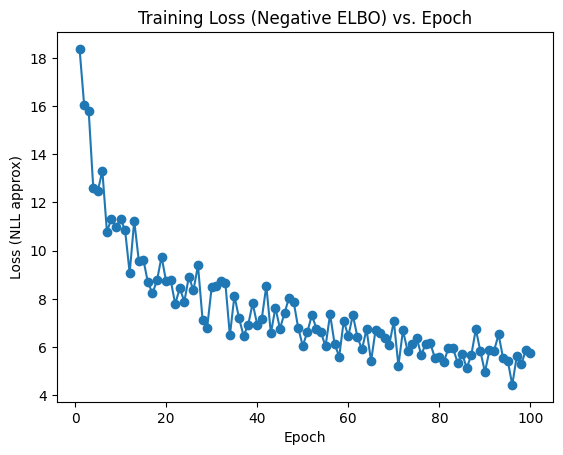

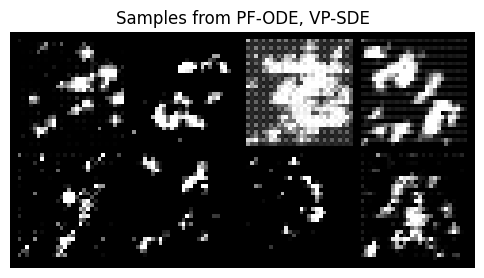

In [18]:
if __name__=="__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x-0.5)*2.),  # map to [-1,1]
    ])
    dataset = datasets.MNIST("./data", download=True, train=True, transform=transform)
    dataloader = data.DataLoader(dataset, batch_size=256, shuffle=True)

    score_net = ScoreNet(channels=[32,64,128,256], embed_dim=256).to(device)

    model = VPSDE(score_net, beta_min=0.1, beta_max=20.0).to(device)

    epochs = 100
    losses = train_sde(model, dataloader, device, epochs=epochs, lr=1e-4)


    plt.figure()
    plt.title("Training Loss (Negative ELBO) vs. Epoch")
    plt.plot(range(1, epochs+1), losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLL approx)")
    plt.show()

    # samples with the Probability Flow ODE
    model.eval()
    with torch.no_grad():
        samples, log_px = model.pf_ode_sample(batch_size=8, device=device, num_steps=500)
        samples_01 = 0.5*(samples + 1.0)
        samples_01 = samples_01.clamp(0,1)

        grid = utils.make_grid(samples_01, nrow=4)
        plt.figure(figsize=(6,6))
        plt.axis("off")
        plt.title("Samples from PF-ODE, VP-SDE")
        plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray")
        plt.show()